In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from glob import glob
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Dropout, Activation, UpSampling2D, GlobalMaxPooling2D, multiply
from tensorflow.keras.backend import max
from keras_unet_collection import models, base, utils

2023-04-22 11:21:25.987577: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
import time
import sys
sys.path.insert(0,'../..')
from gp2 import Runner

2023-04-22 11:21:27.548183: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-04-22 11:21:27.788455: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:47:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-22 11:21:27.791022: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:4e:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-22 11:21:27.791041: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-04-22 11:21:27.794529: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-22 

In [4]:
R = Runner(verbose=True, classifier='kattunet2d')

2023-04-22 11:21:27.855663: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-22 11:21:28.136946: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:47:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-22 11:21:28.139400: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:4e:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-22 11:21:28.148979: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible 

*** GP2 KATTUnet2D ***
Working directory: /tmp/tmp3e5q2vokGP2
Verbose mode active!
Model: "attunet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
attunet_down0_0 (Conv2D)        (None, 512, 512, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
attunet_down0_0_bn (BatchNormal (None, 512, 512, 32) 128         attunet_down0_0[0][0]            
__________________________________________________________________________________________________
attunet_down0_0_activation (ReL (None, 512, 512, 32) 0           attunet_down0_0_bn[0][0]         
___

In [5]:
# load our larger toy dataset (10k images and masks)
images = np.load('/hpcstor6/scratch01/r/ryan.zurrin001/GP2TOYEXAMPLE_LARGE/images.npy')
masks = np.load('/hpcstor6/scratch01/r/ryan.zurrin001/GP2TOYEXAMPLE_LARGE/masks.npy')

In [6]:
images = images[:5000]
masks = masks[:5000]

In [7]:
images.shape

(5000, 512, 512, 1)

In [8]:
masks.shape

(5000, 512, 512, 1)

In [9]:
print(images.max())

255


In [10]:
print(images.min())

0


In [11]:
print(masks.max())

True


In [12]:
weights = {
    'A': 0.5,
    'A_train': 0.1,
    'A_val': 0.3,
    'A_test': 0.6,
    'B': 0.3,
    'B_train': 0.7,
    'B_val': 0.1,
    'B_test': 0.2,
    'Z': 0.2
}
PERCENT_TO_REPLACE = 30

In [13]:
R.setup_data(images, masks, dataset_size=5000, weights=weights)

Weights OK!


In [14]:
RUNS = 5

In [15]:
for run in range(RUNS):
    print('***')
    print('RUN:', run)
    t0 = time.time()
    R.run_classifier()
    R.run_discriminator()
    l = R.find_machine_labels()
    if l == 0:
        print('No more machine labels.')
        print('TOOK', time.time()-t0, 'seconds')
        break
    R.relabel(percent_to_replace=PERCENT_TO_REPLACE)
    print('TOOK', time.time()-t0, 'seconds')


***
RUN: 0


2023-04-22 11:21:36.249248: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-22 11:21:36.266994: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245755000 Hz


Epoch 1/100


2023-04-22 11:21:40.102625: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-04-22 11:21:40.855349: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-04-22 11:21:41.549837: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-04-22 11:21:41.549861: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-04-22 11:21:41.549924: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-04-22 11:21:41.570140: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-22 11:21:42.433769: I tensorflow/stream_exec

4/4 [==============================] - 136s 22s/step - loss: 1.0730 - dice_coef: 0.1975 - val_loss: 0.9346 - val_dice_coef: 0.1930


2023-04-22 11:23:56.198308: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/100
4/4 [==============================] - 6s 2s/step - loss: 1.0736 - dice_coef: 0.1974 - val_loss: 0.8560 - val_dice_coef: 0.1876


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/100
4/4 [==============================] - 6s 2s/step - loss: 1.0734 - dice_coef: 0.1973 - val_loss: 0.8241 - val_dice_coef: 0.1854


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Model saved to: /tmp/tmp3e5q2vokGP2/attunet_0attunet_model
History saved to: /tmp/tmp3e5q2vokGP2/attunet_history_0.pkl
Testing the classifier...
Model saved to /tmp/tmp3e5q2vokGP2/cnnd_0.model
History saved to /tmp/tmp3e5q2vokGP2/cnnd_history_0.pickle
Testing the discriminator...
10/10 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Found 132 machine labels.
Machine labels [  2   3   6   7   8  11  13  18  19  22  23  27  29  32  35  40  42  43
  45  49  51  52  53  54  57  62  63  64  67  71  73  78  79  80  81  86
  87  88  90  94  98 101 102 104 106 108 111 113 117 122 123 125 129 130
 132 138 143 144 145 146 149 150 151 152 153 154 157 158 161 162 163 165
 167 168 169 171 172 174 175 184 187 190 191 192 193 194 201 202 203 205
 207 210 213 214 215 221 222 223 224 226 227 237 241 243 245 246 247 248
 250 251 252 253 254 255 257 258 260 261 263 265 269 272 273 274 275 279
 280 286 289 291 294 298]
D_ids ['2226fc7c-39ca-4c0c-892c-38457c460771', '9

Epoch 1/100


2023-04-22 11:27:12.437908: W tensorflow/core/common_runtime/bfc_allocator.cc:456] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.00GiB (rounded to 4294967296)requested by op gradient_tape/attunet_model/attunet_up5_att_phi_g/Cast/Cast
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-22 11:27:12.437976: I tensorflow/core/common_runtime/bfc_allocator.cc:991] BFCAllocator dump for GPU_0_bfc
2023-04-22 11:27:12.437986: I tensorflow/core/common_runtime/bfc_allocator.cc:998] Bin (256): 	Total Chunks: 329, Chunks in use: 329. 82.2KiB allocated for chunks. 82.2KiB in use in bin. 23.4KiB client-requested in use in bin.
2023-04-22 11:27:12.437992: I tensorflow/core/common_runtime/bfc_allocator.cc:998] Bin (512): 	Total Chunks: 58, Chunks in use: 58. 30.5KiB allocated for chunks. 30.5KiB in use in bin. 29.1KiB client-req

ResourceExhaustedError:  OOM when allocating tensor with shape[64,512,512,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/attunet_model/attunet_up5_att_phi_g/Cast/Cast (defined at home/ryan.zurrin001/Projects/CS410-Omama/_EXPERIMENTS/GP2/../../gp2/gp2/base_keras_segmentation_classifier.py:47) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_10536]

Function call stack:
train_function


In [ ]:
R.classifier_scores

In [ ]:
R.discriminator_scores

In [ ]:
R.plot()

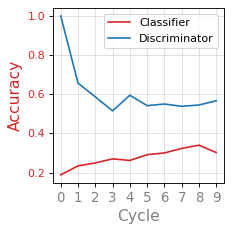

In [18]:
R.plot()

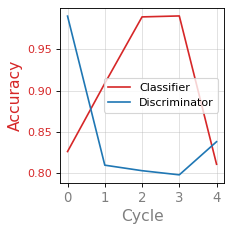

In [17]:
R.plot()